© 2025 Zitao Yang, Rebecca J. Rousseau, Sara Mahdavi, Hernan G. Garcia, and Rob Phillips, *The dynamics of inducible genetic circuits*. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).
___

# Dynamics of auto-activation

In [1]:
import numpy as np
import numpy.random as rng
import matplotlib.pyplot as plt
import math
import param
from scipy.signal import find_peaks
import scipy.optimize
from sympy import *

# Figure formatting

SMALL_SIZE = 15
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['text.usetex'] = True           # use LaTeX rendering for plot text
plt.rcParams['mathtext.fontset'] = 'stix'    # math font size
plt.rcParams['font.family'] = 'STIXGeneral'  # font style
plt.rcParams['axes.labelpad'] = 8.0

In [3]:
def pAct(C, Ka=1.4*10**(-4), Ki=5.3*10**(-7), delE=4.5):
    """ probability of repressor/activator being active
    
    Parameters:
        - C: inducer concentration
        - Ka: dissociation constant in active state
        - Ki: dissociation constant in inactive state
        - delE: energy difference between inactive and active state
    """

    p = (1 + C/Ka)**2 / ((1 + C/Ka)**2 + np.exp(-delE)*(1 + C/Ki)**2)
    return p

## Auto-activation

In [5]:
def AutoActEvolve(p, z, r0, r1, r2, w, d):
    return r0/(1 + 2*(p*z) + w*(p*z)**2) + r1*(2*p*z)/(1 + 2*(p*z) + w*(p*z)**2) + \
            r2*(w*(p*z)**2)/(1 + 2*(p*z) + w*(p*z)**2) - d*z
def prodautoact(A, p, r0, r1, r2, w):
    return r0/(1 + 2*(p*A) + w*(p*A)**2) + r1*(2*p*A)/(1 + 2*(p*A) + w*(p*A)**2) + \
            r2*(w*(p*A)**2)/(1 + 2*(p*A) + w*(p*A)**2)
def degautoact(d, A):
    return d*A
z = Symbol('z')
def f(p, r0, r1, r2, w, d):
    return r0/(1 + 2*(p*z) + w*(p*z)**2) + r1*(2*p*z)/(1 + 2*(p*z) + w*(p*z)**2) + \
            r2*(w*(p*z)**2)/(1 + 2*(p*z) + w*(p*z)**2) - d*z
def steadyStateAutoActivation(p, r0, r1, r2, w):

    coeff = [w*p**2, 2*p-r2*w*p**2, 1-2*r1*p, -r0]

    return np.roots(coeff)

In [7]:
# Create gridspace

Cs = np.logspace(-5.5, -4, 1000)
p_acts = pAct(Cs)

r0, r1, r2 = 0.1, 1, 20
w = 10

length = 2000;
# x-axis: activator concentration (\tilde{A} = A/Kd)
x = np.logspace(-2.5, 2.5, length)
# y-axis: production/degradation rate output
y = np.logspace(-2.5, 0, length)
X, Y = np.meshgrid(x,y)

# Calculate the derivatives at each point
Dx = prodautoact(x, p=p_acts[600], r0=r0, r1=r1, r2=r2, w=w)
Dy = degautoact(d=1, A=x)

# Calculate fixed points and stability

Rs = steadyStateAutoActivation(p=p_acts[600], r0=r0, r1=r1, r2=r2, w=w)
real_Rs = np.real(Rs[np.isreal(Rs)])
fixed_points = real_Rs[real_Rs >= 0]

ff = f(p=p_acts[600], r0=r0, r1=r1, r2=r2, w=w, d=1)
dfdx = diff(ff, z)
fpval = []
stab = []
for i in range(len(fixed_points)):  
    # Define rates at each fp
    yval = prodautoact(A=fixed_points[i], p=p_acts[600], r0=r0, r1=r1, r2=r2, w=w)
    fpval.append(yval)
    # Define stability at each fp
    lambdaval = dfdx.subs(z, fixed_points[i])
    if lambdaval < 0:
        stab.append(0) # stable
    else:
        stab.append(1) # unstable

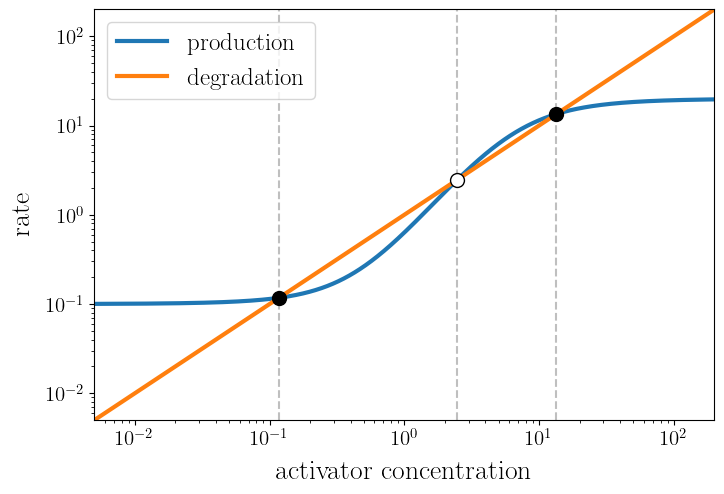

In [9]:
### Plot

bottomlim = 10**(-2.3)
toplim = 10**(2.3)
plt.figure(figsize=(8, 16/3)) # 6 x 4 standard)
plt.plot(x, Dx, linewidth=3, label="production", color="#1f77b4")
plt.plot(x, Dy, linewidth=3, label="degradation", color="#ff7f0e")
for i in range(len(fixed_points)):
    plt.axvline(x = fixed_points[i], color = 'k',linestyle = '--',alpha=0.25)
    if stab[i]==0:
        plt.plot(fixed_points[i], fpval[i], 'o', markersize=10, markerfacecolor='black', markeredgecolor='black')
    else:
        plt.plot(fixed_points[i], fpval[i], 'o', markersize=10, markerfacecolor='white', markeredgecolor='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"activator concentration")
plt.ylabel(r"rate")
plt.ylim(bottomlim, toplim)
plt.xlim(bottomlim, toplim)
plt.legend()
#plt.savefig('autoactphasediagram_w10_r0_01_r1_1_r2_20_vectors.svg', bbox_inches='tight')
plt.show()

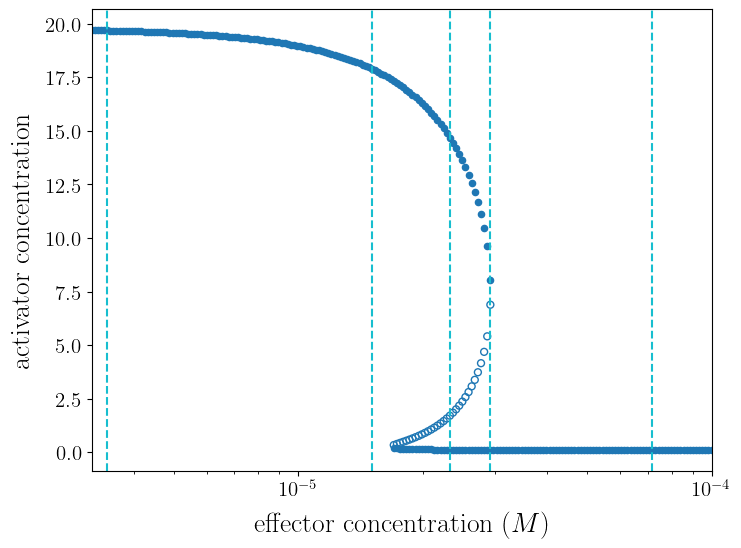

In [27]:
length = 200

Cs = np.logspace(-5.5, -4, length)
p_acts = pAct(Cs)

fig, ax = plt.subplots(figsize=(8,6))

stab = []
unstab = []
positive_Cs_stable = []
positive_Cs_unstable = []
for i in range(len(p_acts)):
    Rs = steadyStateAutoActivation(p=p_acts[i], r0=r0, r1=r1, r2=r2, w=w)
    real_Rs = np.real(Rs[np.isreal(Rs)])
    fixed_points = real_Rs[real_Rs >= 0]
    ff = f(p=p_acts[i], r0=r0, r1=r1, r2=r2, w=w, d=1)
    dfdx = diff(ff, z)
    fpval = []
    for j in range(len(fixed_points)):  
        # Define rates at each fp
        yval = prodautoact(A=fixed_points[j], p=p_acts[i], r0=r0, r1=r1, r2=r2, w=w)
        fpval.append(yval)
        # Define stability at each fp
        lambdaval = dfdx.subs(z, fixed_points[j])
        if np.isreal(yval) == True and yval >= 0:
            if lambdaval < 0:
                stab.append(yval) # stable
                positive_Cs_stable.append(Cs[i])
            else:
                unstab.append(yval) # unstable
                positive_Cs_unstable.append(Cs[i])

ax.scatter(positive_Cs_stable, stab, s=20, marker='o')
ax.scatter(positive_Cs_unstable, unstab, s=25, marker='o', facecolors = 'none', edgecolors = 'tab:blue')

# Optional: can denote the specific timepoints along the bifurcation diagram that will be plotted in the next figure
ax.axvline(x=Cs[5], linestyle='--', color='tab:cyan')
ax.axvline(x=Cs[90], linestyle='--', color='tab:cyan')
ax.axvline(x=Cs[115], linestyle='--', color='tab:cyan')
ax.axvline(x=Cs[128], linestyle='--', color='tab:cyan')
ax.axvline(x=Cs[180], linestyle='--', color='tab:cyan')

ax.set_xlabel(r"effector concentration $(M)$")
ax.set_ylabel(r"activator concentration")
ax.set_xlim(10**(-5.5), 10**(-4))
plt.xscale("log")
#plt.savefig('autoact_bifurcationdiagram.pdf', format='pdf', transparent='True', bbox_inches="tight")
plt.show()

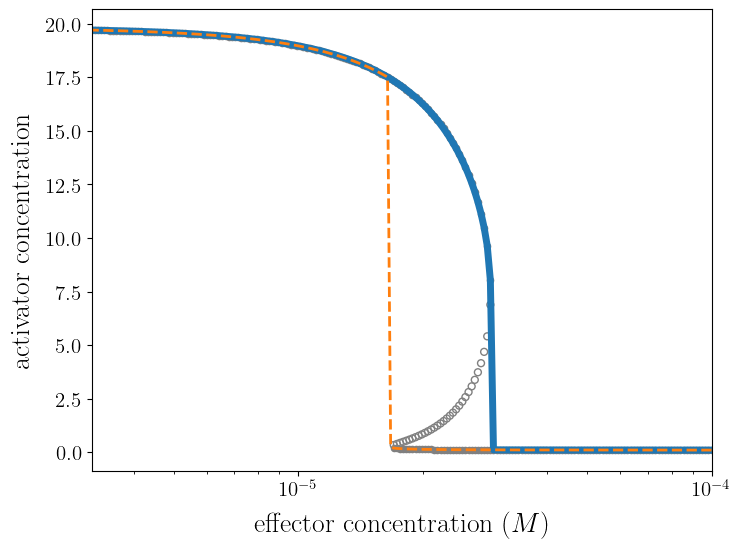

In [29]:
# Demonstrate hysteresis in the bifurcation diagram

Rstab = []
Rstab.insert(0, r2)

tstep = 0.001
steps = 100000

fig, ax = plt.subplots(figsize=(8,6))

for i in range(len(p_acts)):
    for j in range(steps):
        prod = AutoActEvolve(p=p_acts[i],z=Rstab[i],r0=r0, r1=r1,r2=r2,w=w,d=1)
        Rnew = Rstab[i] + (prod*tstep)
        Rstab[i] = Rnew
    if i < len(p_acts)-1:
        Rstab.append(Rstab[i])

# Now do reverse from 0
Csflip = np.flip(Cs)
p_actsflip = pAct(Csflip)

Rstabrev = []
Rstabrev.insert(0, 0)

for i in range(len(p_actsflip)):
    for j in range(steps):
        prod = AutoActEvolve(p=p_actsflip[i],z=Rstabrev[i],r0=r0, r1=r1,r2=r2,w=w,d=1)
        Rnewrev = Rstabrev[i] + (prod*tstep)
        Rstabrev[i] = Rnewrev
    if i < len(p_actsflip)-1:
        Rstabrev.append(Rstabrev[i])

realRstab = np.array(Rstab)

realRstabrev = np.array(Rstabrev)
#realRstabrev = np.flip(realRstabrev)
#Csrev = np.flip(Csflip)

ax.scatter(positive_Cs_stable, stab, s=20, marker='o', facecolors = 'grey', edgecolors = 'grey')
ax.scatter(positive_Cs_unstable, unstab, s=25, marker='o', facecolors = 'none', edgecolors = 'grey')

ax.plot(Cs, realRstab, lw=5)
ax.plot(Csflip, realRstabrev, lw=2, ls='--')
ax.set_xlabel(r"effector concentration $(M)$")
ax.set_ylabel(r"activator concentration")
plt.xscale("log")
plt.xlim(min(Cs), max(Cs))
#plt.savefig('autoact_hysteresis_wbifurc.pdf', format='pdf', transparent='True', bbox_inches="tight")
plt.show()    

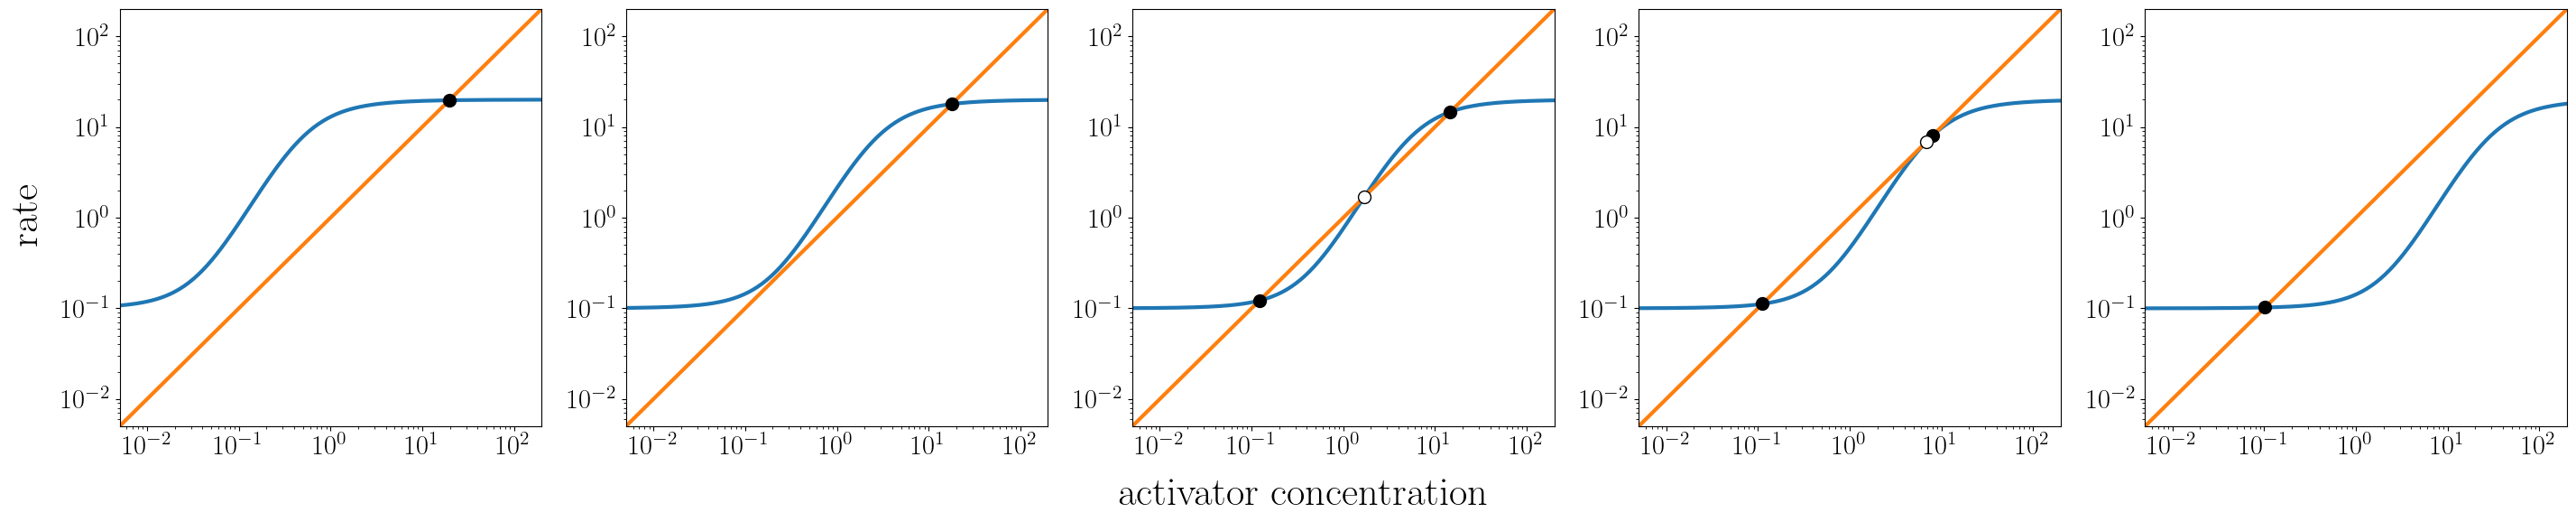

In [31]:
# Plot production and degradation rates of the system at various points in time for the chosen rates/cooperativity

# x-axis: activator concentration
x = np.logspace(-2.5, 2.5, length)
# y-axis: production/degradation rate output
y = np.logspace(-2.5, 0, length)
X, Y = np.meshgrid(x,y)

tslice = [5, 90, 115, 128, 180]

fig, ax = plt.subplots(1,len(tslice), figsize=(35, 6))

for i in range(len(tslice)):

    # Calculate the derivatives at each point
    Dx = prodautoact(x, p=p_acts[tslice[i]], r0=r0, r1=r1, r2=r2, w=w)
    Dy = degautoact(d=1, A=x)
    
    # Calculate fixed points and stability
    
    Rs = steadyStateAutoActivation(p=p_acts[tslice[i]], r0=r0, r1=r1, r2=r2, w=w)
    real_Rs = np.real(Rs[np.isreal(Rs)])
    fixed_points = real_Rs[real_Rs >= 0]
    
    ff = f(p=p_acts[tslice[i]], r0=r0, r1=r1, r2=r2, w=w, d=1)
    dfdx = diff(ff, z)
    fpval = []
    stab = []
    for j in range(len(fixed_points)):  
        # Define rates at each fp
        yval = prodautoact(A=fixed_points[j], p=p_acts[tslice[i]], r0=r0, r1=r1, r2=r2, w=w)
        fpval.append(yval)
        # Define stability at each fp
        lambdaval = dfdx.subs(z, fixed_points[j])
        if lambdaval < 0:
            stab.append(0) # stable
        else:
            stab.append(1) # unstable

    # PLOT
    bottomlim = 10**(-2.3)
    toplim = 10**(2.3)
    ax[i].plot(x, Dx, linewidth=3, label="production", color="#1f77b4")
    ax[i].plot(x, Dy, linewidth=3, label="degradation", color="#ff7f0e")
    for j in range(len(fixed_points)):
        if stab[j]==0:
            ax[i].plot(fixed_points[j], fpval[j], 'o', markersize=10, markerfacecolor='black', markeredgecolor='black')
        else:
            ax[i].plot(fixed_points[j], fpval[j], 'o', markersize=10, markerfacecolor='white', markeredgecolor='black')
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_ylim(bottomlim, toplim)
    ax[i].set_xlim(bottomlim, toplim)
    ax[i].tick_params(axis='x', labelsize=22)
    ax[i].tick_params(axis='y', labelsize=22)
fig.supxlabel(r"activator concentration", y=-0.05, fontsize=32)
fig.supylabel(r"rate", x=0.09, fontsize=32)
#plt.savefig('autoactphasediagram_w10_r0_01_r1_1_r2_20_slices.pdf', format='pdf', transparent='True', bbox_inches='tight')
plt.show()